## Pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import glob

In [2]:
import pandas as pd 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [6]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Conjuntos de treino e teste

São 904 imagens: 337 de 'Burro' e 567 de 'Capivara'.

São reservados 80% do conjunto para treino e 20% para o conjunto de validação.

In [7]:
size = 150
batch_size = 32
img_height = size
img_width = size

In [8]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    class_names=['resized burro', 'resized capivara'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 904 files belonging to 2 classes.
Using 724 files for training.


In [9]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "img/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    class_names=['resized burro', 'resized capivara'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 904 files belonging to 2 classes.
Using 180 files for validation.


In [10]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(ds_validation))

Number of training samples: 23
Number of validation samples: 6


### Plotando alguns exemplos

Aqui é importante notar que, nesse formato sugerido pelo [tutorial](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset) do Keras, o plot das imagens pedido diretamente ao plt.imshow() retorna uma imagem por batch. No primeiro plot 9x9, conseguimos ver 9 imagens porque temos 26 batchs para treino. Quando pedimos para o conjunto de validação ele só retorna 3 imagens (só temos 3 batchs para validação, apesar das 90 imagens).

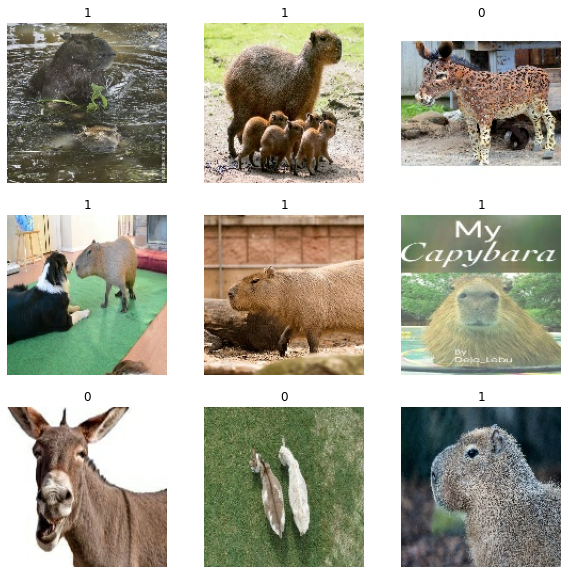

In [99]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0]/255.0)
    plt.title(int(label[0]))
    plt.axis("off")

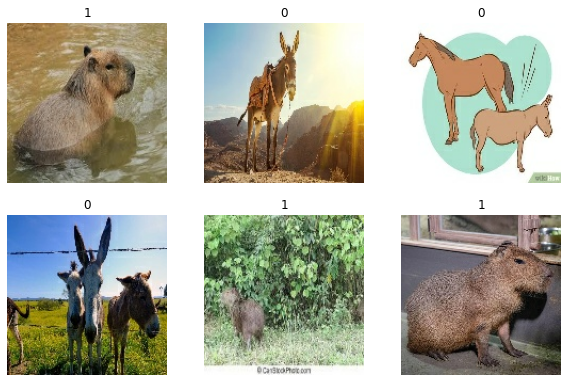

In [100]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_validation.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i]/255.0)
    plt.title(int(label[i]))
    plt.axis("off")

In [101]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(ds_validation))

Number of training samples: 23
Number of validation samples: 6


Para conseguir plotar as imagens de um batch específico é preciso dar 'unbatch' nele usando .unbatch().

Agora conseguimos acessar todas as imagens e plotar elas sem ploblema.

In [11]:
for images, labels in ds_validation:
    print(labels)
    
validation_ds = ds_validation.unbatch()
images = list(validation_ds.map(lambda x, y: x))
labels = list(validation_ds.map(lambda x, y: y))

tf.Tensor([1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1], shape=(20,), dtype=int32)


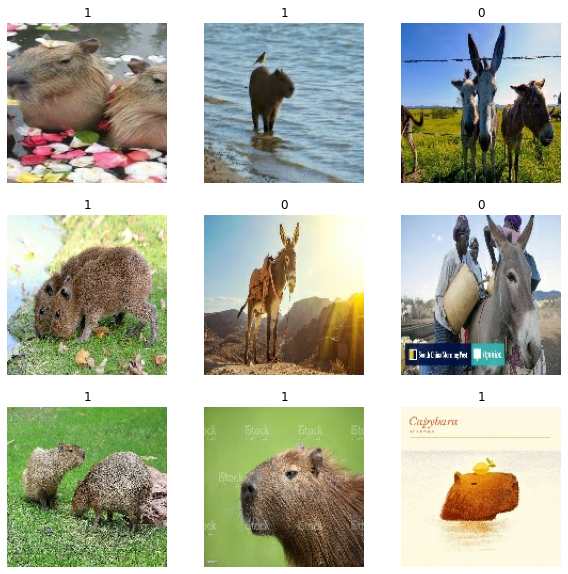

In [58]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(validation_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image/255.0)
    plt.title(int(label))
    plt.axis("off")

## Data augmentations

Agora funciona!

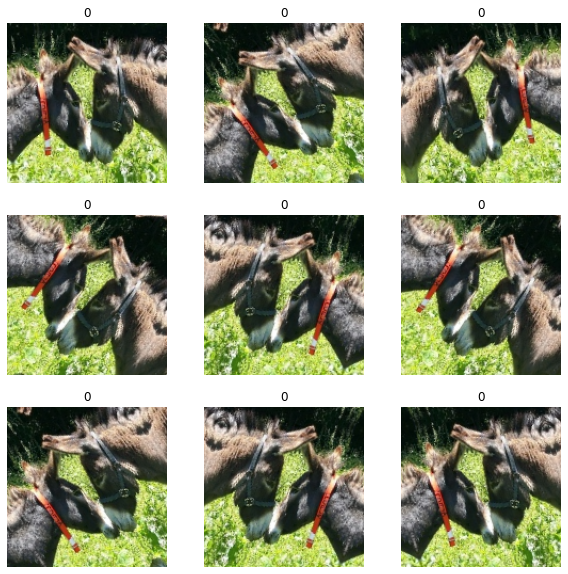

In [103]:
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]/255.0
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0])
        plt.title(int(labels[0]))
        plt.axis("off")

## Construindo o modelo

In [104]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [105]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/20
23/23 [==============================] - 39s 2s/step - loss: 0.3533 - binary_accuracy: 0.8329 - val_loss: 0.1739 - val_binary_accuracy: 0.9222
Epoch 2/20
23/23 [==============================] - 40s 2s/step - loss: 0.1809 - binary_accuracy: 0.9240 - val_loss: 0.1217 - val_binary_accuracy: 0.9500
Epoch 3/20
23/23 [==============================] - 40s 2s/step - loss: 0.1506 - binary_accuracy: 0.9351 - val_loss: 0.1082 - val_binary_accuracy: 0.9444
Epoch 4/20
23/23 [==============================] - 40s 2s/step - loss: 0.1219 - binary_accuracy: 0.9517 - val_loss: 0.0964 - val_binary_accuracy: 0.9611
Epoch 5/20
23/23 [==============================] - 40s 2s/step - loss: 0.1208 - binary_accuracy: 0.9461 - val_loss: 0.0999 - val_binary_accuracy: 0.9611
Epoch 6/20
23/23 [==============================] - 40s 2s/step - loss: 0.1111 - binary_accuracy: 0.9572 - val_loss: 0.0891 - val_binary_accuracy: 0.9556
Epoch 7/20
23/23 [==============================] - 41s 2s/step - loss: 0.08

In [123]:
model.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG2.h5")
print("Saved model to disk")

C:\Users\malta\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


In [12]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['binary_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

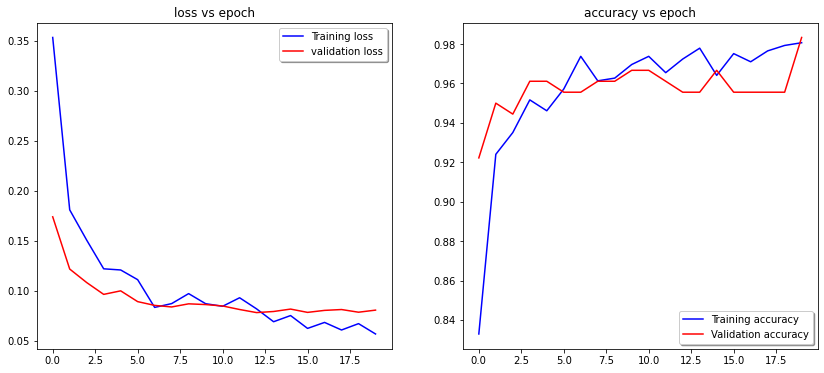

In [106]:
plotLearningCurves(history) 

### Fine tuning

In [124]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_fine = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [125]:
model.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_Fine2.h5")
print("Saved model to disk")

C:\Users\malta\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


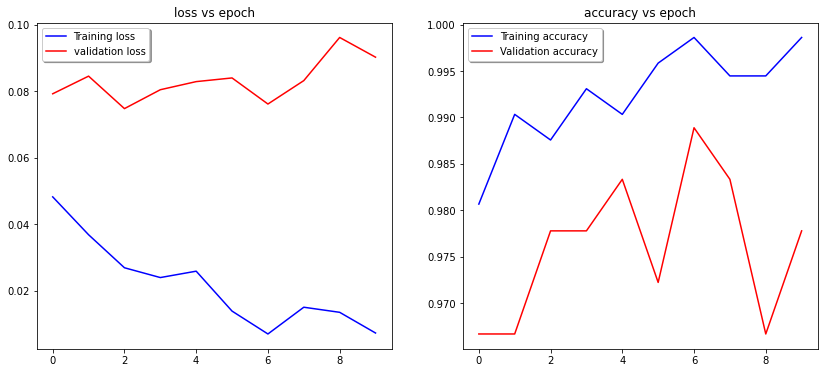

In [126]:
plotLearningCurves(history_fine) 

In [128]:
loss, accuracy = model.evaluate(ds_validation)
print("Accuracy", accuracy)
print("Loss", loss)

6/6 [==============================] - 7s 1s/step - loss: 0.0902 - binary_accuracy: 0.9778
Accuracy 0.9777777791023254
Loss 0.09021495282649994


In [156]:
loss, accuracy = model.evaluate(ds_train)
print("Accuracy", accuracy)
print("Loss", loss)

23/23 [==============================] - 29s 1s/step - loss: 0.0022 - binary_accuracy: 1.0000
Accuracy 1.0
Loss 0.002197400201112032


### Prevendo as imagens

In [ ]:
### Isso aqui foi feito no PyTorch. Vale a pena tentar converter para o Keras
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = to_device(xb, device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

### Classificação e acurácia (isso aqui não deu certo)

In [5]:
model_1 = keras.models.load_model("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1.h5")

In [134]:
y_valid = []
for i in range (0,len(labels)):
    y_valid.append(labels[i].numpy())
y_valid = np.array(y_valid)
type(y_valid)

numpy.ndarray

In [15]:
#predVali = model_1.predict(ds_validation)
predVali = (model_1.predict(ds_validation) > 0.0).astype("int32")
print('validation report:','\n',classification_report(y_valid, predVali))
print('validation accuracy:', accuracy_score(y_valid, predVali))

validation report: 
               precision    recall  f1-score   support

           0       0.42      0.41      0.41        32
           1       0.68      0.69      0.68        58

    accuracy                           0.59        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.59      0.59      0.59        90

validation accuracy: 0.5888888888888889


In [139]:
#for images, labels in ds_train:
#    print(labels)
    
train_ds = ds_train.unbatch()
images_t = list(train_ds.map(lambda x, y: x))
labels_t = list(train_ds.map(lambda x, y: y))

In [160]:
images_t = np.array(images_t)

In [142]:
y_train = []
for i in range (0,len(labels_t)):
    y_train.append(labels_t[i].numpy())
y_train = np.array(y_train)
type(y_train)

numpy.ndarray

In [162]:
#predVali = model_1.predict(ds_validation)
predTrain = (model.predict(images_t) > 0.0).astype("int32")
print('validation report:','\n',classification_report(y_train, predTrain))
print('validation accuracy:', accuracy_score(y_train, predTrain))

validation report: 
               precision    recall  f1-score   support

           0       0.34      0.34      0.34       270
           1       0.61      0.61      0.61       454

    accuracy                           0.51       724
   macro avg       0.47      0.47      0.47       724
weighted avg       0.51      0.51      0.51       724

validation accuracy: 0.505524861878453


In [56]:
#predFine = (model.predict(ds_validation) > 0.0).astype("int32")
#predTest = modelLR.predict(x_test)
print('validation report:','\n',classification_report(y_valid, y_pred))
print('validation accuracy:', accuracy_score(y_valid, y_pred))

validation report: 
               precision    recall  f1-score   support

           0       0.42      0.41      0.41        32
           1       0.68      0.69      0.68        58

    accuracy                           0.59        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.59      0.59      0.59        90

validation accuracy: 0.5888888888888889


In [67]:
loss, accuracy = model.evaluate(ds_validation)
print("Accuracy", accuracy)
print("Loss", loss)

3/3 [==============================] - 4s 1s/step - loss: 0.1022 - binary_accuracy: 0.9889
Accuracy 0.9888888597488403
Loss 0.10224083811044693


In [ ]:
(model_1.predict(ds_validation) > 0.0).astype("int32")

In [77]:
predicted = (model.predict(ds_validation) > 0.0).astype("int32")
cf = confusion_matrix(y_valid, predicted)

In [78]:
cf

array([[13, 19],
       [18, 40]], dtype=int64)

In [82]:
ds_validation.class_names

['resized burro', 'resized capivara']

In [ ]:
true_classes = ds_validation.class_names
class_labels = list(test_data_generator.class_indices.keys())   

In [86]:
train_ds

<_UnbatchDataset shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int32)>

In [87]:
# get predict prob and label 
ypred = model.predict(ds_train, verbose=1)
ypred = np.argmax(ypred, axis=1)

26/26 [==============================] - 32s 1s/step


In [90]:
print(classification_report(np.argmax(y_train, axis=1), ypred, target_names=target_names))


AxisError: axis 1 is out of bounds for array of dimension 1

In [8]:
import os

def load_images_from_folder(foldername):
    image = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername,filename))
        if img is not None:
            image.append(img)
    return image
img_capivara=load_images_from_folder('img/resized capivara')
img_burro=load_images_from_folder('img/resized burro')
labels_capivara = [1] * len(img_capivara)
labels_burro = [0] * len(img_burro)

In [17]:
print(len(img_capivara), len(img_burro))
print(len(labels_capivara), len(labels_burro))

567 337
567 337


In [29]:
#Criando um data frame
df = pd.DataFrame(index=np.arange(2*len(img_burro)), columns=["Classe","Imagem"])
df["Classe"] = 0

In [30]:
len(df['Classe'])

674

In [45]:
len(img_burro)

337

In [72]:
for i in range(0,len(img_burro)):
    df['Classe'][i] = 0
    df['Imagem'][i] = img_burro[i]
for i in range(len(img_burro),len(df['Classe'])-1):
    df['Classe'][i] = 1
for i in range(0,len(img_burro)):
    df['Imagem'][i+337] = img_capivara[i]

In [73]:
df['Classe'].value_counts()

0    337
1    337
Name: Classe, dtype: int64

In [33]:
df['Classe'].value_counts()/len(df['Classe'])

0    0.5
1    0.5
Name: Classe, dtype: float64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(Xtrain_raw, ytrain_raw, test_size = 0.2, random_state = 3)
x_test, y_test = Xtest_raw, ytest_raw

## Comparando com outros modelos

### Modelo sem os pesos do Imagenet

In [13]:
base_model_no_weight = keras.applications.Xception(
    weights=None,  # Random inicialization.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model_no_weight.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model_no_weight(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model_no_weight = keras.Model(inputs, outputs)

model_no_weight.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [14]:
model_no_weight.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history_no_weight = model_no_weight.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/20
23/23 [==============================] - 55s 2s/step - loss: 0.6919 - binary_accuracy: 0.3729 - val_loss: 0.6908 - val_binary_accuracy: 0.3722
Epoch 2/20
23/23 [==============================] - 50s 2s/step - loss: 0.6895 - binary_accuracy: 0.3729 - val_loss: 0.6885 - val_binary_accuracy: 0.3722
Epoch 3/20
23/23 [==============================] - 41s 2s/step - loss: 0.6874 - binary_accuracy: 0.3729 - val_loss: 0.6863 - val_binary_accuracy: 0.3722
Epoch 4/20
23/23 [==============================] - 40s 2s/step - loss: 0.6853 - binary_accuracy: 0.3729 - val_loss: 0.6844 - val_binary_accuracy: 0.3722
Epoch 5/20
23/23 [==============================] - 40s 2s/step - loss: 0.6834 - binary_accuracy: 0.3729 - val_loss: 0.6825 - val_binary_accuracy: 0.3722
Epoch 6/20
23/23 [==============================] - 40s 2s/step - loss: 0.6816 - binary_accuracy: 0.3729 - val_loss: 0.6808 - val_binary_accuracy: 0.3722
Epoch 7/20
23/23 [==============================] - 41s 2s/step - loss: 0.68

In [15]:
model_no_weight.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_no_weight.h5")
print("Saved model to disk")

Saved model to disk


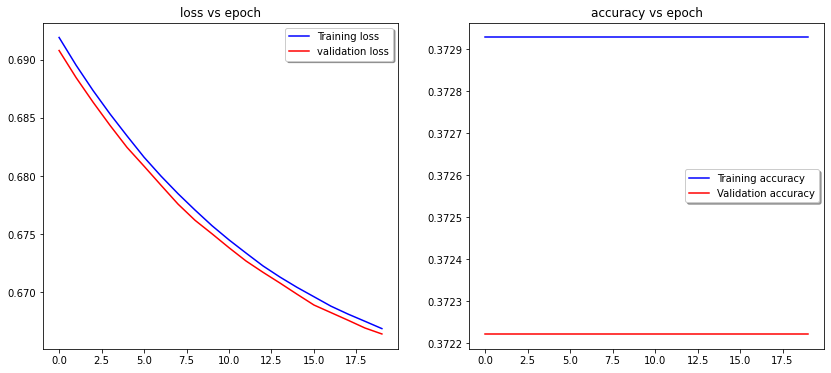

In [16]:
plotLearningCurves(history_no_weight) 

In [18]:
base_model_no_weight.trainable = True
model_no_weight.summary()

model_no_weight.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_fine_no_weight = model_no_weight.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [22]:
model_no_weight.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_no_weight_Fine.h5")
print("Saved model to disk")

Saved model to disk


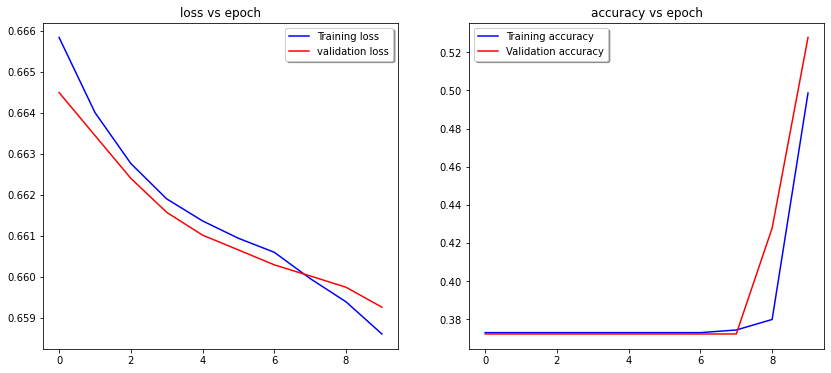

In [23]:
plotLearningCurves(history_fine_no_weight) 

In [20]:
loss, accuracy = model_no_weight.evaluate(ds_validation)
print("Accuracy", accuracy)
print("Loss", loss)

6/6 [==============================] - 7s 1s/step - loss: 0.6593 - binary_accuracy: 0.5278
Accuracy 0.5277777910232544
Loss 0.6592617630958557


In [21]:
loss, accuracy = model_no_weight.evaluate(ds_train)
print("Accuracy", accuracy)
print("Loss", loss)

23/23 [==============================] - 31s 1s/step - loss: 0.6577 - binary_accuracy: 0.6326
Accuracy 0.6325966715812683
Loss 0.657685399055481


### Modelo sem o imagenet

In [25]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model_no_imagenet = keras.Model(inputs, outputs)

model_no_imagenet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 global_average_pooling2d_2   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                           

In [26]:
model_no_imagenet.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history_no_imagenet = model_no_imagenet.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/20
23/23 [==============================] - 2s 74ms/step - loss: 0.6815 - binary_accuracy: 0.3757 - val_loss: 0.6885 - val_binary_accuracy: 0.3722
Epoch 2/20
23/23 [==============================] - 2s 70ms/step - loss: 0.6757 - binary_accuracy: 0.3771 - val_loss: 0.6862 - val_binary_accuracy: 0.3722
Epoch 3/20
23/23 [==============================] - 2s 67ms/step - loss: 0.6776 - binary_accuracy: 0.3743 - val_loss: 0.6841 - val_binary_accuracy: 0.3722
Epoch 4/20
23/23 [==============================] - 2s 63ms/step - loss: 0.6719 - binary_accuracy: 0.3798 - val_loss: 0.6820 - val_binary_accuracy: 0.3722
Epoch 5/20
23/23 [==============================] - 2s 63ms/step - loss: 0.6686 - binary_accuracy: 0.3826 - val_loss: 0.6803 - val_binary_accuracy: 0.3722
Epoch 6/20
23/23 [==============================] - 2s 66ms/step - loss: 0.6706 - binary_accuracy: 0.3895 - val_loss: 0.6788 - val_binary_accuracy: 0.3722
Epoch 7/20
23/23 [==============================] - 2s 63ms/step - los

In [27]:
model_no_imagenet.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_no_imagenet.h5")
print("Saved model to disk")

Saved model to disk


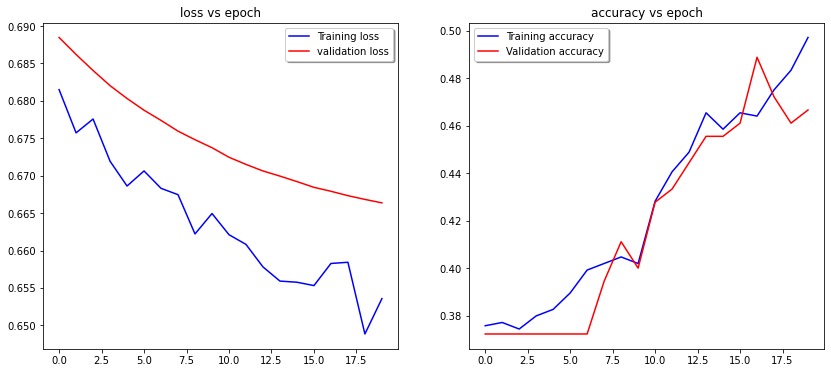

In [28]:
plotLearningCurves(history_no_imagenet) 

In [29]:
model_no_imagenet.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_fine_no_imagenet = model_no_imagenet.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/10
23/23 [==============================] - 2s 70ms/step - loss: 0.6565 - binary_accuracy: 0.4682 - val_loss: 0.6664 - val_binary_accuracy: 0.4667
Epoch 2/10
23/23 [==============================] - 2s 66ms/step - loss: 0.6544 - binary_accuracy: 0.4986 - val_loss: 0.6664 - val_binary_accuracy: 0.4667
Epoch 3/10
23/23 [==============================] - 2s 63ms/step - loss: 0.6546 - binary_accuracy: 0.4890 - val_loss: 0.6664 - val_binary_accuracy: 0.4667
Epoch 4/10
23/23 [==============================] - 2s 61ms/step - loss: 0.6512 - binary_accuracy: 0.4986 - val_loss: 0.6664 - val_binary_accuracy: 0.4667
Epoch 5/10
23/23 [==============================] - 2s 63ms/step - loss: 0.6516 - binary_accuracy: 0.4945 - val_loss: 0.6663 - val_binary_accuracy: 0.4667
Epoch 6/10
23/23 [==============================] - 2s 63ms/step - loss: 0.6539 - binary_accuracy: 0.4862 - val_loss: 0.6663 - val_binary_accuracy: 0.4667
Epoch 7/10
23/23 [==============================] - 2s 64ms/step - los

In [30]:
model_no_imagenet.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_no_imagenet_Fine.h5")
print("Saved model to disk")

Saved model to disk


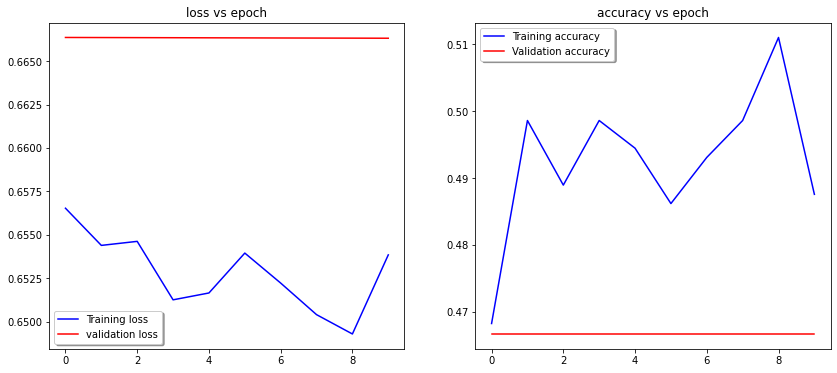

In [31]:
plotLearningCurves(history_fine_no_imagenet) 

In [32]:
loss, accuracy = model_no_imagenet.evaluate(ds_validation)
print("Accuracy", accuracy)
print("Loss", loss)

6/6 [==============================] - 0s 7ms/step - loss: 0.6663 - binary_accuracy: 0.4667
Accuracy 0.46666666865348816
Loss 0.6663199663162231


In [33]:
loss, accuracy = model_no_imagenet.evaluate(ds_train)
print("Accuracy", accuracy)
print("Loss", loss)

23/23 [==============================] - 0s 14ms/step - loss: 0.6497 - binary_accuracy: 0.5000
Accuracy 0.5
Loss 0.6496677398681641


### Modelo sem o imagenet com o mesmo tempo de treinamento

In [39]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model_no_imagenet_tempo = keras.Model(inputs, outputs)

model_no_imagenet_tempo.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 global_average_pooling2d_5   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                           

In [40]:
model_no_imagenet_tempo.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 400
history_no_imagenet_tempo = model_no_imagenet_tempo.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/400
23/23 [==============================] - 2s 75ms/step - loss: 0.7354 - binary_accuracy: 0.3812 - val_loss: 0.7033 - val_binary_accuracy: 0.4222
Epoch 2/400
23/23 [==============================] - 2s 62ms/step - loss: 0.7212 - binary_accuracy: 0.3950 - val_loss: 0.6997 - val_binary_accuracy: 0.4222
Epoch 3/400
23/23 [==============================] - 2s 63ms/step - loss: 0.7299 - binary_accuracy: 0.3771 - val_loss: 0.6962 - val_binary_accuracy: 0.4222
Epoch 4/400
23/23 [==============================] - 2s 64ms/step - loss: 0.7259 - binary_accuracy: 0.3867 - val_loss: 0.6928 - val_binary_accuracy: 0.4222
Epoch 5/400
23/23 [==============================] - 2s 63ms/step - loss: 0.7170 - binary_accuracy: 0.3854 - val_loss: 0.6899 - val_binary_accuracy: 0.4222
Epoch 6/400
23/23 [==============================] - 2s 64ms/step - loss: 0.7174 - binary_accuracy: 0.3812 - val_loss: 0.6871 - val_binary_accuracy: 0.4222
Epoch 7/400
23/23 [==============================] - 2s 66ms/ste

23/23 [==============================] - 2s 67ms/step - loss: 0.6467 - binary_accuracy: 0.6464 - val_loss: 0.6584 - val_binary_accuracy: 0.5333
Epoch 106/400
23/23 [==============================] - 1s 58ms/step - loss: 0.6438 - binary_accuracy: 0.6312 - val_loss: 0.6584 - val_binary_accuracy: 0.5278
Epoch 107/400
23/23 [==============================] - 2s 63ms/step - loss: 0.6492 - binary_accuracy: 0.5912 - val_loss: 0.6585 - val_binary_accuracy: 0.5278
Epoch 108/400
23/23 [==============================] - 2s 68ms/step - loss: 0.6431 - binary_accuracy: 0.6160 - val_loss: 0.6586 - val_binary_accuracy: 0.5278
Epoch 109/400
23/23 [==============================] - 2s 86ms/step - loss: 0.6443 - binary_accuracy: 0.6174 - val_loss: 0.6586 - val_binary_accuracy: 0.5278
Epoch 110/400
23/23 [==============================] - 2s 93ms/step - loss: 0.6470 - binary_accuracy: 0.6036 - val_loss: 0.6585 - val_binary_accuracy: 0.5333
Epoch 111/400
23/23 [==============================] - 2s 70ms/ste

Epoch 157/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6427 - binary_accuracy: 0.6091 - val_loss: 0.6573 - val_binary_accuracy: 0.5111
Epoch 158/400
23/23 [==============================] - 2s 68ms/step - loss: 0.6340 - binary_accuracy: 0.6423 - val_loss: 0.6574 - val_binary_accuracy: 0.5111
Epoch 159/400
23/23 [==============================] - 2s 68ms/step - loss: 0.6405 - binary_accuracy: 0.6202 - val_loss: 0.6574 - val_binary_accuracy: 0.5111
Epoch 160/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6449 - binary_accuracy: 0.6022 - val_loss: 0.6574 - val_binary_accuracy: 0.5111
Epoch 161/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6431 - binary_accuracy: 0.6133 - val_loss: 0.6574 - val_binary_accuracy: 0.5111
Epoch 162/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6340 - binary_accuracy: 0.6077 - val_loss: 0.6574 - val_binary_accuracy: 0.5111
Epoch 163/400
23/23 [==============================]

Epoch 209/400
23/23 [==============================] - 2s 69ms/step - loss: 0.6334 - binary_accuracy: 0.6326 - val_loss: 0.6561 - val_binary_accuracy: 0.5333
Epoch 210/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6415 - binary_accuracy: 0.6091 - val_loss: 0.6561 - val_binary_accuracy: 0.5278
Epoch 211/400
23/23 [==============================] - 2s 68ms/step - loss: 0.6448 - binary_accuracy: 0.5967 - val_loss: 0.6560 - val_binary_accuracy: 0.5278
Epoch 212/400
23/23 [==============================] - 2s 66ms/step - loss: 0.6355 - binary_accuracy: 0.6202 - val_loss: 0.6559 - val_binary_accuracy: 0.5278
Epoch 213/400
23/23 [==============================] - 2s 66ms/step - loss: 0.6295 - binary_accuracy: 0.6243 - val_loss: 0.6558 - val_binary_accuracy: 0.5278
Epoch 214/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6436 - binary_accuracy: 0.5843 - val_loss: 0.6559 - val_binary_accuracy: 0.5278
Epoch 215/400
23/23 [==============================]

23/23 [==============================] - 2s 70ms/step - loss: 0.6324 - binary_accuracy: 0.6146 - val_loss: 0.6544 - val_binary_accuracy: 0.5389
Epoch 312/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6417 - binary_accuracy: 0.5994 - val_loss: 0.6544 - val_binary_accuracy: 0.5389
Epoch 313/400
23/23 [==============================] - 2s 65ms/step - loss: 0.6379 - binary_accuracy: 0.6077 - val_loss: 0.6544 - val_binary_accuracy: 0.5389
Epoch 314/400
23/23 [==============================] - 2s 67ms/step - loss: 0.6490 - binary_accuracy: 0.6050 - val_loss: 0.6544 - val_binary_accuracy: 0.5389
Epoch 315/400
23/23 [==============================] - 2s 64ms/step - loss: 0.6300 - binary_accuracy: 0.6036 - val_loss: 0.6544 - val_binary_accuracy: 0.5389
Epoch 316/400
23/23 [==============================] - 2s 65ms/step - loss: 0.6403 - binary_accuracy: 0.6036 - val_loss: 0.6543 - val_binary_accuracy: 0.5389
Epoch 317/400
23/23 [==============================] - 2s 64ms/ste

In [41]:
model_no_imagenet_tempo.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/modelIMG1_no_imagenet_tempo.h5")
print("Saved model to disk")

Saved model to disk


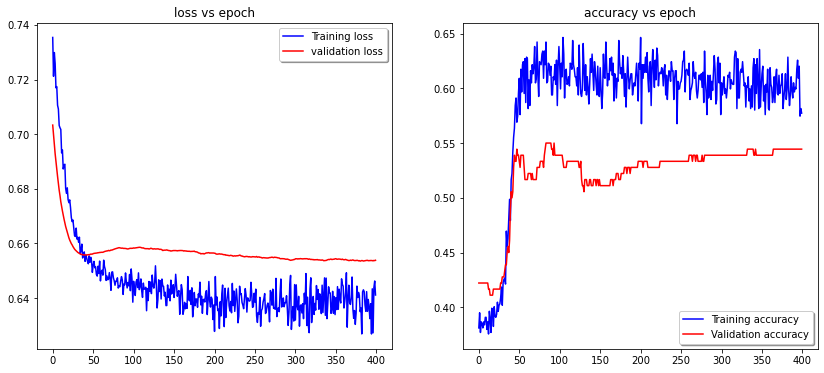

In [42]:
plotLearningCurves(history_no_imagenet_tempo) 